In [16]:
# ============================================================================
# 📦 INSTALAÇÃO E IMPORTAÇÃO DE BIBLIOTECAS
# ============================================================================

!pip install imbalanced-learn -q

In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (classification_report, confusion_matrix,
                             accuracy_score, f1_score, precision_score,
                             recall_score, roc_auc_score, roc_curve)

# Modelos
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier

# Seleção de Features
from sklearn.feature_selection import SelectKBest, f_classif, RFE

# Balanceamento
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTETomek

import warnings
warnings.filterwarnings('ignore')

# Configurações de visualização
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

In [18]:
"""# 📊 1. CARREGAMENTO E ANÁLISE EXPLORATÓRIA DOS DADOS"""

# Carregar o dataset
# IMPORTANTE: Substitua o caminho abaixo pelo seu dataset
# Exemplo com dataset do Kaggle: https://www.kaggle.com/mlg-ulb/creditcardfraud

# Para upload de arquivo no Colab:
from google.colab import files
print("📁 Faça upload do arquivo CSV do dataset de fraudes:")
uploaded = files.upload()

# Obter o nome do arquivo
filename = list(uploaded.keys())[0]
df = pd.read_csv(filename)

print("=" * 80)
print("📋 INFORMAÇÕES DO DATASET")
print("=" * 80)
print(f"Shape: {df.shape}")
print(f"\nPrimeiras linhas:")
print(df.head())
print(f"\nInformações das colunas:")
print(df.info())
print(f"\nEstatísticas descritivas:")
print(df.describe())

📁 Faça upload do arquivo CSV do dataset de fraudes:


Saving creditcard - menor balanceado.csv to creditcard - menor balanceado (1).csv
📋 INFORMAÇÕES DO DATASET
Shape: (1759, 31)

Primeiras linhas:
       Time        V1        V2        V3        V4        V5        V6  \
0   82450.0  1.314539  0.590643 -0.666593  0.716564  0.301978 -1.125467   
1   50554.0 -0.798672  1.185093  0.904547  0.694584  0.219041 -0.319295   
2   55125.0 -0.391128 -0.245540  1.122074 -1.308725 -0.639891  0.008678   
3  116572.0 -0.060302  1.065093 -0.987421 -0.029567  0.176376 -1.348539   
4   90434.0  1.848433  0.373364  0.269272  3.866438  0.088062  0.970447   

         V7        V8        V9  ...       V21       V22       V23       V24  \
0  0.388881 -0.288390 -0.132137  ... -0.170307 -0.429655 -0.141341 -0.200195   
1  0.495236  0.139269 -0.760214  ...  0.202287  0.578699 -0.092245  0.013723   
2 -0.701304 -0.027315 -2.628854  ... -0.133485  0.117403 -0.191748 -0.488642   
3  0.775644  0.134843 -0.149734  ...  0.355576  0.907570 -0.018454 -0.126269   
4 -0.


❓ Valores nulos por coluna:
Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64

⚖️ ANÁLISE DO DESBALANCEAMENTO
Coluna target: Class

Distribuição das classes:
Class
0    1267
1     492
Name: count, dtype: int64

Percentual:
Class
0    72.029562
1    27.970438
Name: proportion, dtype: float64


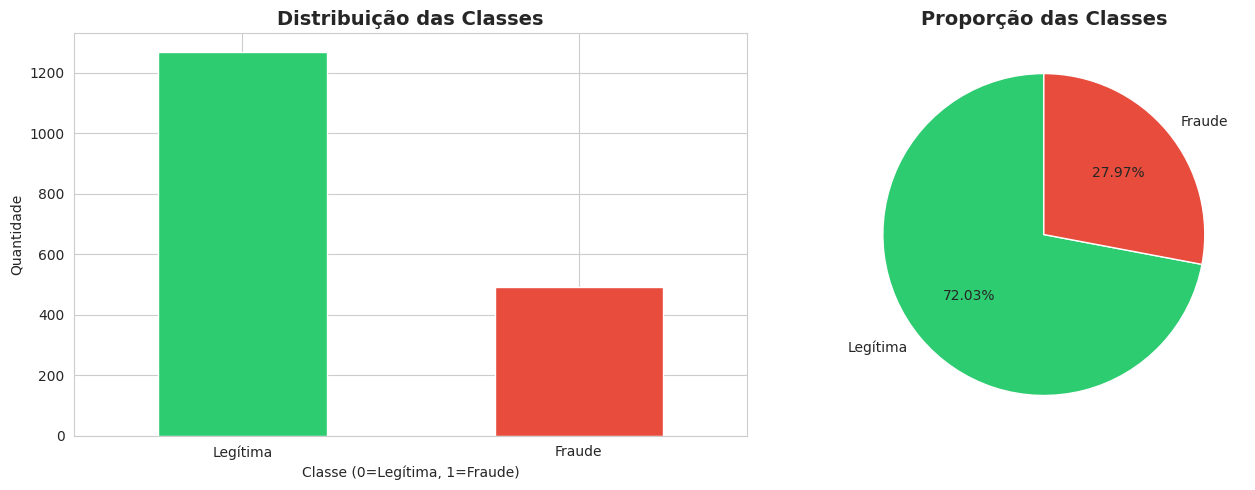

In [19]:
# Verificar valores nulos
print(f"\n❓ Valores nulos por coluna:")
print(df.isnull().sum())

# Análise do desbalanceamento
print("\n" + "=" * 80)
print("⚖️ ANÁLISE DO DESBALANCEAMENTO")
print("=" * 80)

# Assumindo que a coluna target é 'Class' (ajuste se necessário)
target_col = 'Class' if 'Class' in df.columns else df.columns[-1]
print(f"Coluna target: {target_col}")

fraud_counts = df[target_col].value_counts()
print(f"\nDistribuição das classes:")
print(fraud_counts)
print(f"\nPercentual:")
print(df[target_col].value_counts(normalize=True) * 100)

# Visualização do desbalanceamento
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Gráfico de barras
fraud_counts.plot(kind='bar', ax=axes[0], color=['#2ecc71', '#e74c3c'])
axes[0].set_title('Distribuição das Classes', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Classe (0=Legítima, 1=Fraude)')
axes[0].set_ylabel('Quantidade')
axes[0].set_xticklabels(['Legítima', 'Fraude'], rotation=0)

# Gráfico de pizza
colors = ['#2ecc71', '#e74c3c']
axes[1].pie(fraud_counts, labels=['Legítima', 'Fraude'], autopct='%1.2f%%',
            colors=colors, startangle=90)
axes[1].set_title('Proporção das Classes', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

In [20]:
"""# 🔧 2. PRÉ-PROCESSAMENTO DOS DADOS"""

# Separar features e target
X = df.drop(target_col, axis=1)
y = df[target_col]

print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")

# Split treino/teste
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

print(f"\nTreino: {X_train.shape}, Teste: {X_test.shape}")
print(f"Distribuição no treino:\n{y_train.value_counts()}")
print(f"Distribuição no teste:\n{y_test.value_counts()}")

# Normalização dos dados
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("\n✅ Dados normalizados com StandardScaler")

Features shape: (1759, 30)
Target shape: (1759,)

Treino: (1231, 30), Teste: (528, 30)
Distribuição no treino:
Class
0    887
1    344
Name: count, dtype: int64
Distribuição no teste:
Class
0    380
1    148
Name: count, dtype: int64

✅ Dados normalizados com StandardScaler


🔍 SELEÇÃO DE ATRIBUTOS

📊 Método 1: SelectKBest
Features selecionadas (20): ['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V9', 'V10', 'V11', 'V12', 'V14', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V28']

🌲 Método 2: Feature Importance (Random Forest)

Top 10 features mais importantes:
   feature  importance
14     V14    0.172347
10     V10    0.146219
17     V17    0.101411
12     V12    0.095788
4       V4    0.085175
11     V11    0.064303
16     V16    0.057006
3       V3    0.054454
2       V2    0.037098
9       V9    0.027530


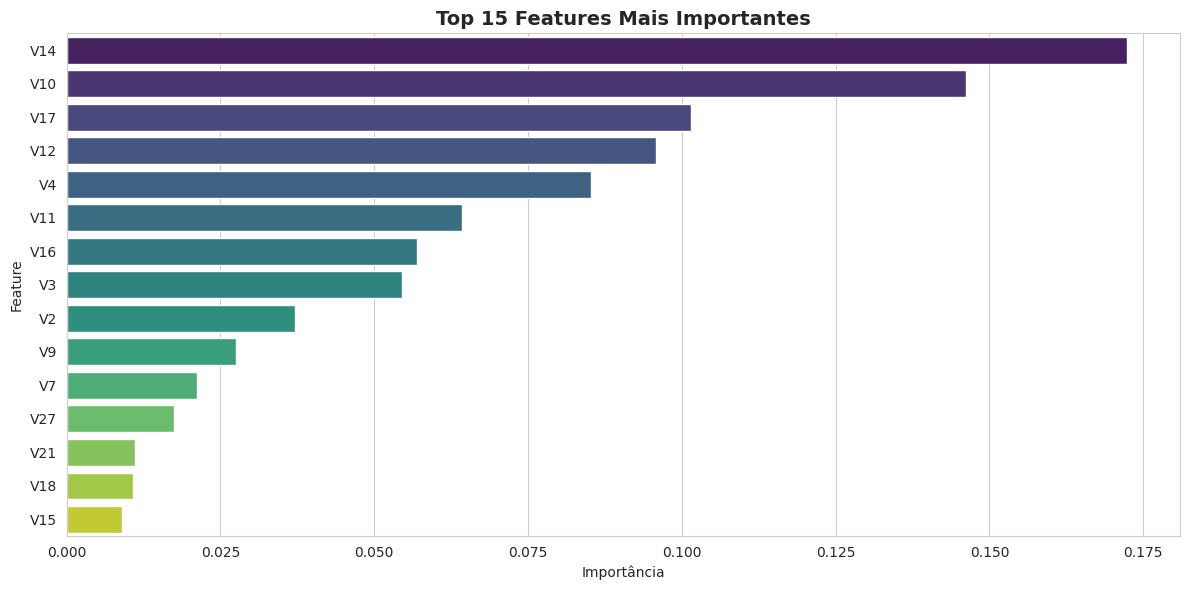


✅ Usando top 20 features para os próximos experimentos


In [21]:
"""# 🎯 3. SELEÇÃO DE ATRIBUTOS (FEATURE SELECTION)"""

print("=" * 80)
print("🔍 SELEÇÃO DE ATRIBUTOS")
print("=" * 80)

# 3.1 SelectKBest
print("\n📊 Método 1: SelectKBest")
k_best = SelectKBest(score_func=f_classif, k=20)
X_train_kbest = k_best.fit_transform(X_train_scaled, y_train)
X_test_kbest = k_best.transform(X_test_scaled)

selected_features_kbest = X.columns[k_best.get_support()].tolist()
print(f"Features selecionadas ({len(selected_features_kbest)}): {selected_features_kbest}")

# 3.2 Feature Importance com Random Forest
print("\n🌲 Método 2: Feature Importance (Random Forest)")
rf_temp = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf_temp.fit(X_train_scaled, y_train)

feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': rf_temp.feature_importances_
}).sort_values('importance', ascending=False)

print("\nTop 10 features mais importantes:")
print(feature_importance.head(10))

# Visualizar importância das features
plt.figure(figsize=(12, 6))
top_n = 15
sns.barplot(data=feature_importance.head(top_n), x='importance', y='feature', palette='viridis')
plt.title(f'Top {top_n} Features Mais Importantes', fontsize=14, fontweight='bold')
plt.xlabel('Importância')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

# Selecionar top features
top_features = feature_importance.head(20)['feature'].tolist()
X_train_top = X_train[top_features]
X_test_top = X_test[top_features]

# Normalizar novamente
X_train_top_scaled = scaler.fit_transform(X_train_top)
X_test_top_scaled = scaler.transform(X_test_top)

print(f"\n✅ Usando top {len(top_features)} features para os próximos experimentos")

⚖️ TÉCNICAS DE BALANCEAMENTO

🔼 Aplicando SMOTE...
Shape após SMOTE: (1774, 20)
Distribuição: Class
0    887
1    887
Name: count, dtype: int64

🔽 Aplicando Random Undersampling...
Shape após Undersampling: (688, 20)
Distribuição: Class
0    344
1    344
Name: count, dtype: int64

⚖️ Aplicando SMOTETomek...
Shape após SMOTETomek: (1766, 20)
Distribuição: Class
0    883
1    883
Name: count, dtype: int64


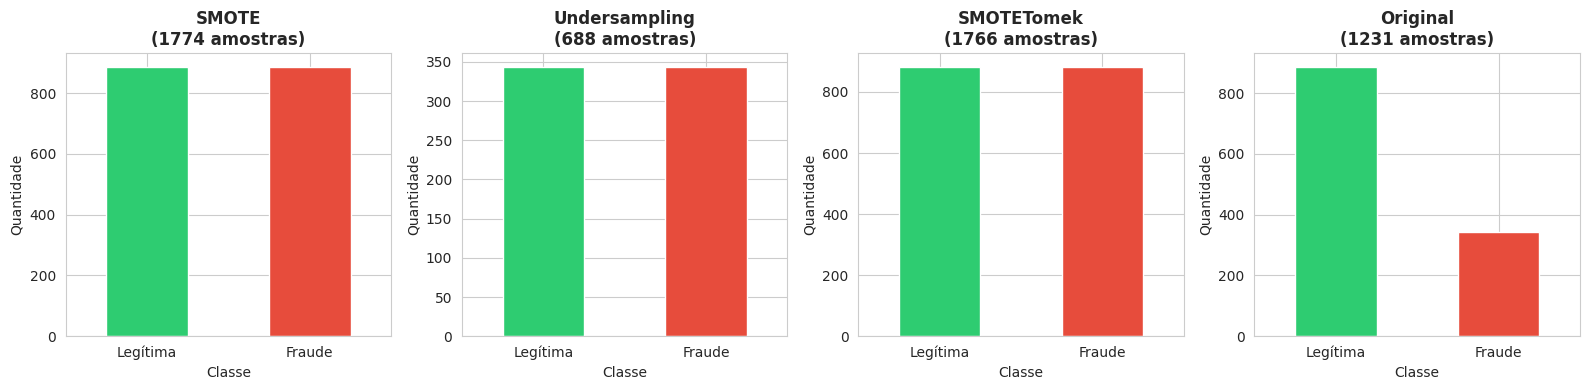

In [22]:
"""# ⚖️ 4. TÉCNICAS DE BALANCEAMENTO (SAMPLING)"""

print("=" * 80)
print("⚖️ TÉCNICAS DE BALANCEAMENTO")
print("=" * 80)

# Dicionário para armazenar datasets balanceados
balanced_datasets = {}

# 4.1 SMOTE (Oversampling)
print("\n🔼 Aplicando SMOTE...")
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_top_scaled, y_train)
balanced_datasets['SMOTE'] = (X_train_smote, y_train_smote)
print(f"Shape após SMOTE: {X_train_smote.shape}")
print(f"Distribuição: {pd.Series(y_train_smote).value_counts()}")

# 4.2 Random Undersampling
print("\n🔽 Aplicando Random Undersampling...")
rus = RandomUnderSampler(random_state=42)
X_train_rus, y_train_rus = rus.fit_resample(X_train_top_scaled, y_train)
balanced_datasets['Undersampling'] = (X_train_rus, y_train_rus)
print(f"Shape após Undersampling: {X_train_rus.shape}")
print(f"Distribuição: {pd.Series(y_train_rus).value_counts()}")

# 4.3 SMOTETomek (Combinado)
print("\n⚖️ Aplicando SMOTETomek...")
smote_tomek = SMOTETomek(random_state=42)
X_train_combined, y_train_combined = smote_tomek.fit_resample(X_train_top_scaled, y_train)
balanced_datasets['SMOTETomek'] = (X_train_combined, y_train_combined)
print(f"Shape após SMOTETomek: {X_train_combined.shape}")
print(f"Distribuição: {pd.Series(y_train_combined).value_counts()}")

# Dataset original (sem balanceamento)
balanced_datasets['Original'] = (X_train_top_scaled, y_train)

# Visualizar comparação
fig, axes = plt.subplots(1, 4, figsize=(16, 4))
for idx, (name, (X_bal, y_bal)) in enumerate(balanced_datasets.items()):
    pd.Series(y_bal).value_counts().plot(kind='bar', ax=axes[idx], color=['#2ecc71', '#e74c3c'])
    axes[idx].set_title(f'{name}\n({len(y_bal)} amostras)', fontweight='bold')
    axes[idx].set_xlabel('Classe')
    axes[idx].set_ylabel('Quantidade')
    axes[idx].set_xticklabels(['Legítima', 'Fraude'], rotation=0)

plt.tight_layout()
plt.show()

🤖 TREINAMENTO DE MODELOS BASE

Testando com: SMOTE
  → Treinando Random Forest... ✓ Macro F1: 0.9468
  → Treinando Decision Tree... ✓ Macro F1: 0.8929
  → Treinando XGBoost... ✓ Macro F1: 0.9362
  → Treinando SVM... ✓ Macro F1: 0.9498
  → Treinando KNN... ✓ Macro F1: 0.9304

Testando com: Undersampling
  → Treinando Random Forest... ✓ Macro F1: 0.9340
  → Treinando Decision Tree... ✓ Macro F1: 0.8903
  → Treinando XGBoost... ✓ Macro F1: 0.9233
  → Treinando SVM... ✓ Macro F1: 0.9498
  → Treinando KNN... ✓ Macro F1: 0.9425

Testando com: SMOTETomek
  → Treinando Random Forest... ✓ Macro F1: 0.9518
  → Treinando Decision Tree... ✓ Macro F1: 0.8963
  → Treinando XGBoost... ✓ Macro F1: 0.9293
  → Treinando SVM... ✓ Macro F1: 0.9498
  → Treinando KNN... ✓ Macro F1: 0.9280

Testando com: Original
  → Treinando Random Forest... ✓ Macro F1: 0.9417
  → Treinando Decision Tree... ✓ Macro F1: 0.8959
  → Treinando XGBoost... ✓ Macro F1: 0.9329
  → Treinando SVM... ✓ Macro F1: 0.9365
  → Treinando 

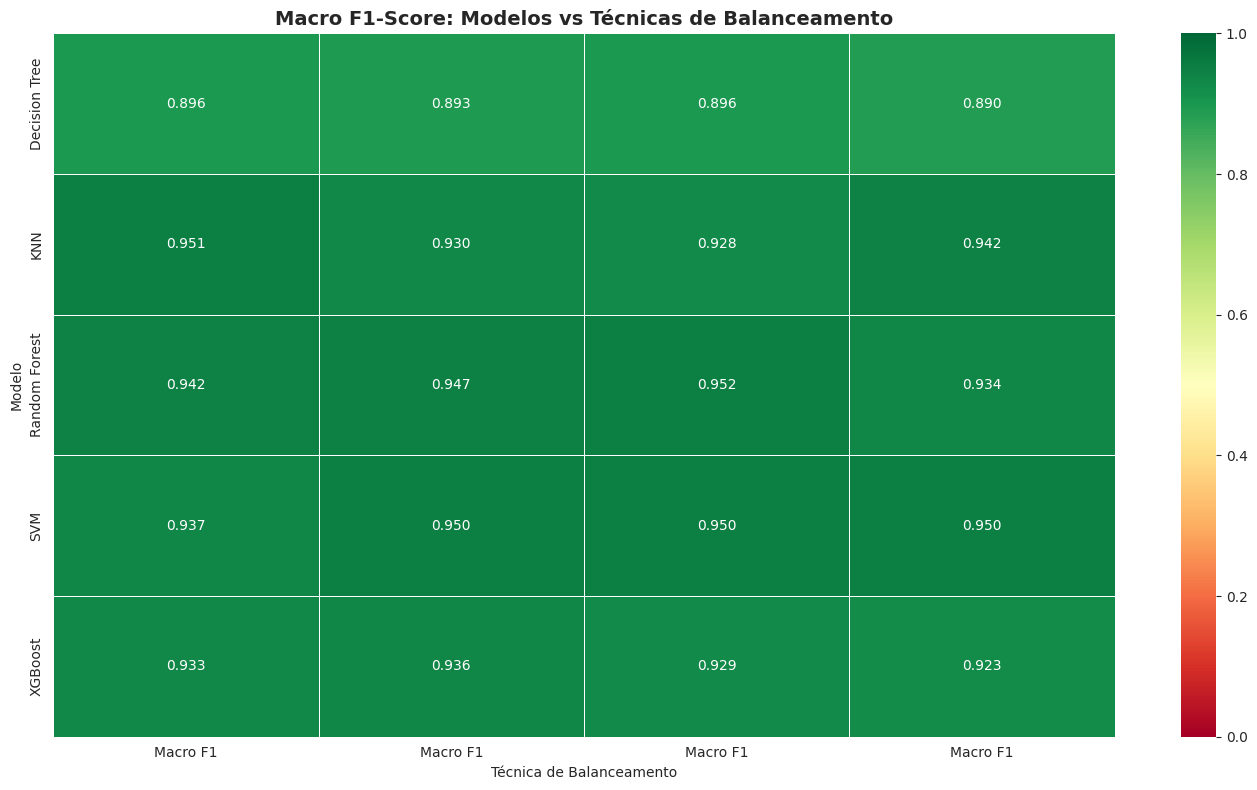

In [23]:
"""# 🤖 5. TREINAMENTO DE MODELOS BASE"""

print("=" * 80)
print("🤖 TREINAMENTO DE MODELOS BASE")
print("=" * 80)

# Função para avaliar modelo
def evaluate_model(model, X_train, y_train, X_test, y_test, model_name):
    """Treina e avalia um modelo"""
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    results = {
        'Model': model_name,
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1-Score': f1_score(y_test, y_pred),
        'Macro F1': f1_score(y_test, y_pred, average='macro')
    }

    return results, y_pred

# Modelos base para testar
base_models = {
    'Random Forest': RandomForestClassifier(random_state=42, n_jobs=-1),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'XGBoost': XGBClassifier(random_state=42, eval_metric='logloss', n_jobs=-1),
    'SVM': SVC(random_state=42),
    'KNN': KNeighborsClassifier(n_jobs=-1)
}

# Testar cada técnica de balanceamento com cada modelo
all_results = []

for balance_name, (X_bal, y_bal) in balanced_datasets.items():
    print(f"\n{'='*60}")
    print(f"Testando com: {balance_name}")
    print(f"{'='*60}")

    for model_name, model in base_models.items():
        print(f"  → Treinando {model_name}...", end=' ')
        results, y_pred = evaluate_model(
            model, X_bal, y_bal, X_test_top_scaled, y_test,
            f"{model_name} ({balance_name})"
        )
        all_results.append(results)
        print(f"✓ Macro F1: {results['Macro F1']:.4f}")

# Criar DataFrame com resultados
results_df = pd.DataFrame(all_results)
results_df = results_df.sort_values('Macro F1', ascending=False)

print("\n" + "=" * 80)
print("📊 RESULTADOS DOS MODELOS BASE")
print("=" * 80)
print(results_df.to_string(index=False))

# Visualizar comparação
plt.figure(figsize=(14, 8))
results_pivot = results_df.pivot_table(
    values='Macro F1',
    index=results_df['Model'].str.split(' \(').str[0],
    columns=results_df['Model'].str.extract(r'\((.*?)\)')[0],
    aggfunc='first'
)

sns.heatmap(results_pivot, annot=True, fmt='.3f', cmap='RdYlGn',
            vmin=0, vmax=1, linewidths=0.5)
plt.title('Macro F1-Score: Modelos vs Técnicas de Balanceamento',
          fontsize=14, fontweight='bold')
plt.xlabel('Técnica de Balanceamento')
plt.ylabel('Modelo')
plt.tight_layout()
plt.show()

In [25]:
"""# 🎛️ 6. TUNING DE HIPERPARÂMETROS (OTIMIZADO)"""

print("=" * 80)
print("🎛️ TUNING DE HIPERPARÂMETROS (VERSÃO OTIMIZADA)")
print("=" * 80)

# Selecionar o melhor dataset de balanceamento (baseado nos resultados anteriores)
# Vamos usar SMOTE como exemplo
X_train_final, y_train_final = balanced_datasets['SMOTE']

# OPÇÃO RÁPIDA: Usar apenas RandomizedSearchCV com menos iterações
# e grids menores para acelerar o processo

# 6.1 Random Forest com RandomizedSearchCV (MAIS RÁPIDO)
print("\n🌲 Tunando Random Forest (otimizado)...")
rf_params = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'class_weight': ['balanced', None]
}

rf_random = RandomizedSearchCV(
    RandomForestClassifier(random_state=42, n_jobs=-1),
    rf_params,
    n_iter=10,  # Apenas 10 combinações
    cv=3,
    scoring='f1_macro',
    random_state=42,
    n_jobs=-1,
    verbose=1
)

rf_random.fit(X_train_final, y_train_final)
print(f"✅ Melhores parâmetros RF: {rf_random.best_params_}")
print(f"✅ Melhor score RF: {rf_random.best_score_:.4f}")

best_rf = rf_random.best_estimator_

# 6.2 XGBoost com RandomizedSearchCV (OTIMIZADO)
print("\n⚡ Tunando XGBoost (otimizado)...")
xgb_params = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.05, 0.1, 0.2],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
    'scale_pos_weight': [1, 5]
}

xgb_random = RandomizedSearchCV(
    XGBClassifier(random_state=42, eval_metric='logloss', n_jobs=-1),
    xgb_params,
    n_iter=10,  # Apenas 10 combinações
    cv=3,
    scoring='f1_macro',
    random_state=42,
    n_jobs=-1,
    verbose=1
)

xgb_random.fit(X_train_final, y_train_final)
print(f"✅ Melhores parâmetros XGB: {xgb_random.best_params_}")
print(f"✅ Melhor score XGB: {xgb_random.best_score_:.4f}")

best_xgb = xgb_random.best_estimator_

# 6.3 Decision Tree (MODELO SIMPLES E RÁPIDO)
print("\n🌳 Tunando Decision Tree (rápido)...")
dt_params = {
    'max_depth': [10, 20, 30],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'class_weight': ['balanced', None]
}

dt_random = RandomizedSearchCV(
    DecisionTreeClassifier(random_state=42),
    dt_params,
    n_iter=8,
    cv=3,
    scoring='f1_macro',
    random_state=42,
    n_jobs=-1,
    verbose=1
)

dt_random.fit(X_train_final, y_train_final)
print(f"✅ Melhores parâmetros DT: {dt_random.best_params_}")
print(f"✅ Melhor score DT: {dt_random.best_score_:.4f}")

best_dt = dt_random.best_estimator_

# Nota: Removemos o SVM do tuning pois é muito lento para datasets grandes
# Vamos usar um SVM com parâmetros padrão otimizados
print("\n🎯 Usando SVM com parâmetros padrão otimizados...")
best_svm = SVC(C=1, kernel='rbf', gamma='scale', class_weight='balanced', random_state=42)
best_svm.fit(X_train_final, y_train_final)
print("✅ SVM treinado com parâmetros padrão")

🎛️ TUNING DE HIPERPARÂMETROS (VERSÃO OTIMIZADA)

🌲 Tunando Random Forest (otimizado)...
Fitting 3 folds for each of 10 candidates, totalling 30 fits
✅ Melhores parâmetros RF: {'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': None, 'class_weight': None}
✅ Melhor score RF: 0.9628

⚡ Tunando XGBoost (otimizado)...
Fitting 3 folds for each of 10 candidates, totalling 30 fits
✅ Melhores parâmetros XGB: {'subsample': 0.8, 'scale_pos_weight': 5, 'n_estimators': 100, 'max_depth': 7, 'learning_rate': 0.2, 'colsample_bytree': 0.8}
✅ Melhor score XGB: 0.9724

🌳 Tunando Decision Tree (rápido)...
Fitting 3 folds for each of 8 candidates, totalling 24 fits
✅ Melhores parâmetros DT: {'min_samples_split': 5, 'min_samples_leaf': 1, 'max_depth': 30, 'class_weight': 'balanced'}
✅ Melhor score DT: 0.9391

🎯 Usando SVM com parâmetros padrão otimizados...
✅ SVM treinado com parâmetros padrão


🎪 ENSEMBLE DE MODELOS

🗳️ Criando Voting Classifier (Hard Voting)...
✅ Voting Classifier (Hard) treinado

🗳️ Criando Voting Classifier (Soft Voting)...
✅ Voting Classifier (Soft) treinado

📊 RESULTADOS DOS ENSEMBLES
                Model  Accuracy  Precision   Recall  F1-Score  Macro F1
          Voting Soft  0.962121   0.963768 0.898649  0.930070  0.952048
          Voting Hard  0.962121   0.963768 0.898649  0.930070  0.952048
          SVM (Tuned)  0.960227   0.956835 0.898649  0.926829  0.949761
Random Forest (Tuned)  0.958333   0.970149 0.878378  0.921986  0.946781
      XGBoost (Tuned)  0.941288   0.887417 0.905405  0.896321  0.927685


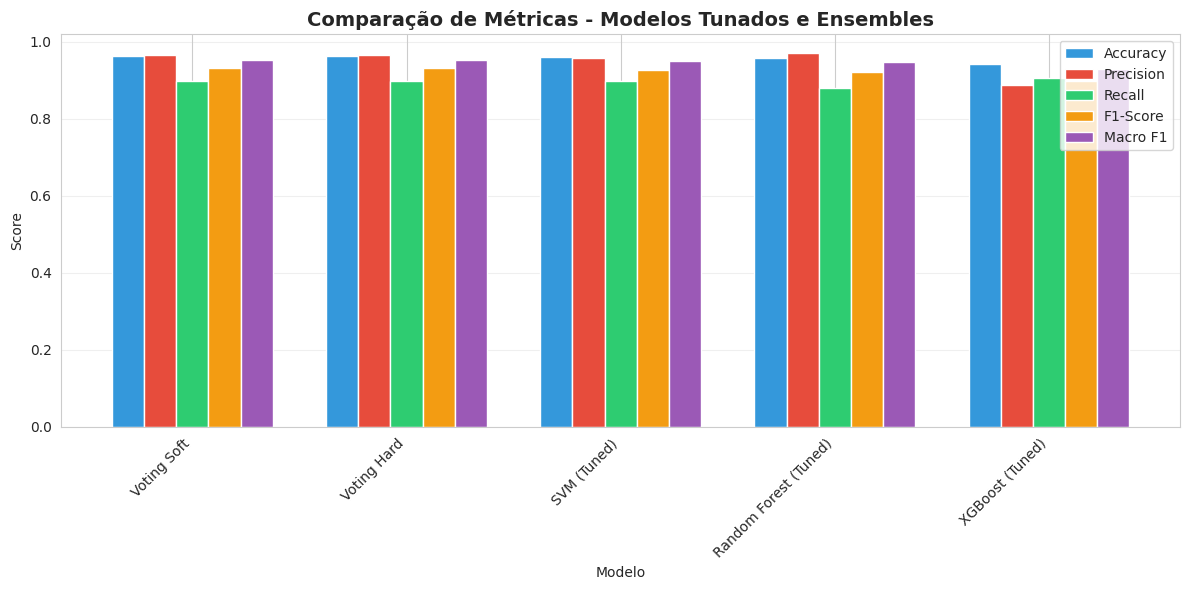

In [26]:
"""# 🎪 7. ENSEMBLE DE MODELOS"""

print("=" * 80)
print("🎪 ENSEMBLE DE MODELOS")
print("=" * 80)

# 7.1 Voting Classifier (Hard Voting)
print("\n🗳️ Criando Voting Classifier (Hard Voting)...")
voting_hard = VotingClassifier(
    estimators=[
        ('rf', best_rf),
        ('xgb', best_xgb),
        ('svm', best_svm)
    ],
    voting='hard'
)

voting_hard.fit(X_train_final, y_train_final)
print("✅ Voting Classifier (Hard) treinado")

# 7.2 Voting Classifier (Soft Voting)
print("\n🗳️ Criando Voting Classifier (Soft Voting)...")
# Treinar SVM com probability=True para soft voting
best_svm_prob = SVC(
    **{k: v for k, v in best_svm.get_params().items() if k not in ['random_state', 'probability']},
    probability=True,
    random_state=42
)
best_svm_prob.fit(X_train_final, y_train_final)

voting_soft = VotingClassifier(
    estimators=[
        ('rf', best_rf),
        ('xgb', best_xgb),
        ('svm', best_svm_prob)
    ],
    voting='soft'
)

voting_soft.fit(X_train_final, y_train_final)
print("✅ Voting Classifier (Soft) treinado")

# Avaliar ensembles
ensemble_results = []

models_to_evaluate = {
    'Random Forest (Tuned)': best_rf,
    'XGBoost (Tuned)': best_xgb,
    'SVM (Tuned)': best_svm,
    'Voting Hard': voting_hard,
    'Voting Soft': voting_soft
}

for name, model in models_to_evaluate.items():
    results, _ = evaluate_model(
        model, X_train_final, y_train_final,
        X_test_top_scaled, y_test, name
    )
    ensemble_results.append(results)

ensemble_df = pd.DataFrame(ensemble_results)
ensemble_df = ensemble_df.sort_values('Macro F1', ascending=False)

print("\n" + "=" * 80)
print("📊 RESULTADOS DOS ENSEMBLES")
print("=" * 80)
print(ensemble_df.to_string(index=False))

# Visualizar comparação
fig, ax = plt.subplots(figsize=(12, 6))
x = np.arange(len(ensemble_df))
width = 0.15

metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'Macro F1']
colors = ['#3498db', '#e74c3c', '#2ecc71', '#f39c12', '#9b59b6']

for i, metric in enumerate(metrics):
    ax.bar(x + i*width, ensemble_df[metric], width, label=metric, color=colors[i])

ax.set_xlabel('Modelo')
ax.set_ylabel('Score')
ax.set_title('Comparação de Métricas - Modelos Tunados e Ensembles',
             fontsize=14, fontweight='bold')
ax.set_xticks(x + width * 2)
ax.set_xticklabels(ensemble_df['Model'], rotation=45, ha='right')
ax.legend()
ax.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

📈 AVALIAÇÃO FINAL DO MELHOR MODELO

🏆 Melhor modelo: Voting Soft
🎯 Macro F1-Score: 0.9520

📋 CLASSIFICATION REPORT
              precision    recall  f1-score   support

    Legítima     0.9615    0.9868    0.9740       380
      Fraude     0.9638    0.8986    0.9301       148

    accuracy                         0.9621       528
   macro avg     0.9627    0.9427    0.9520       528
weighted avg     0.9622    0.9621    0.9617       528



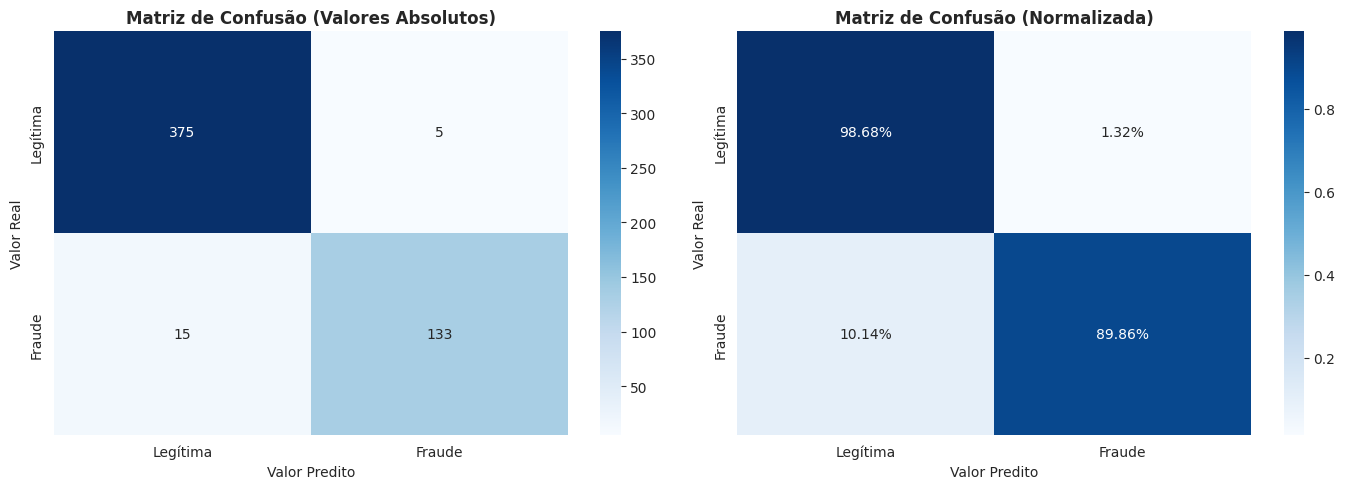


📊 Análise da Matriz de Confusão:
  • True Negatives (TN):  375 - Legítimas corretamente identificadas
  • False Positives (FP): 5 - Legítimas classificadas como fraude
  • False Negatives (FN): 15 - Fraudes NÃO detectadas ⚠️
  • True Positives (TP):  133 - Fraudes corretamente detectadas ✓


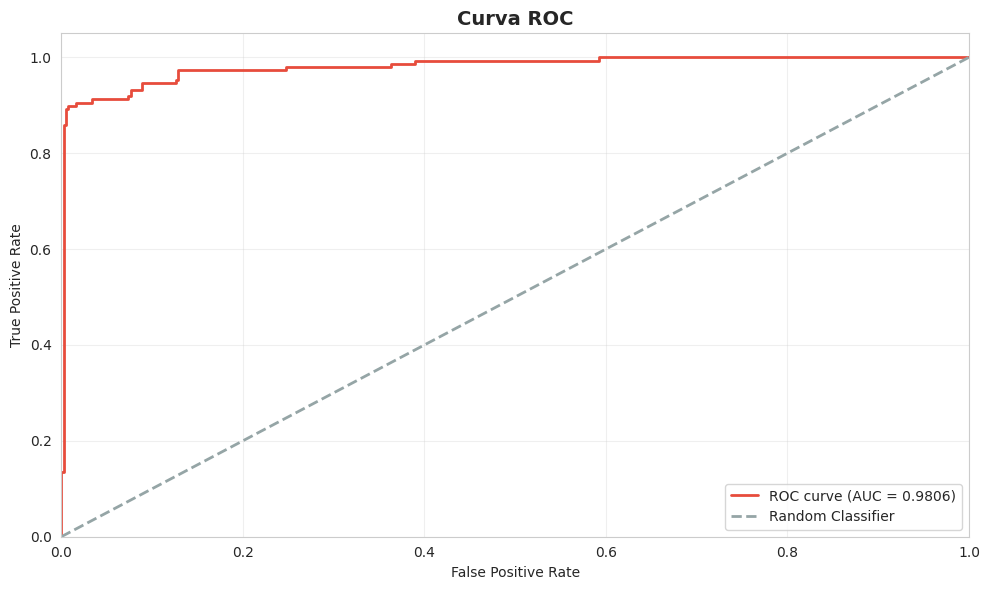


📊 AUC-ROC Score: 0.9806
📊 ANÁLISE COMPARATIVA DAS TÉCNICAS

1️⃣ IMPACTO DAS TÉCNICAS DE BALANCEAMENTO
------------------------------------------------------------
                   mean       std       max
Balance                                    
Original       0.931622  0.021142  0.951175
SMOTE          0.931224  0.022800  0.949761
SMOTETomek     0.931027  0.022385  0.951835
Undersampling  0.927979  0.023230  0.949761


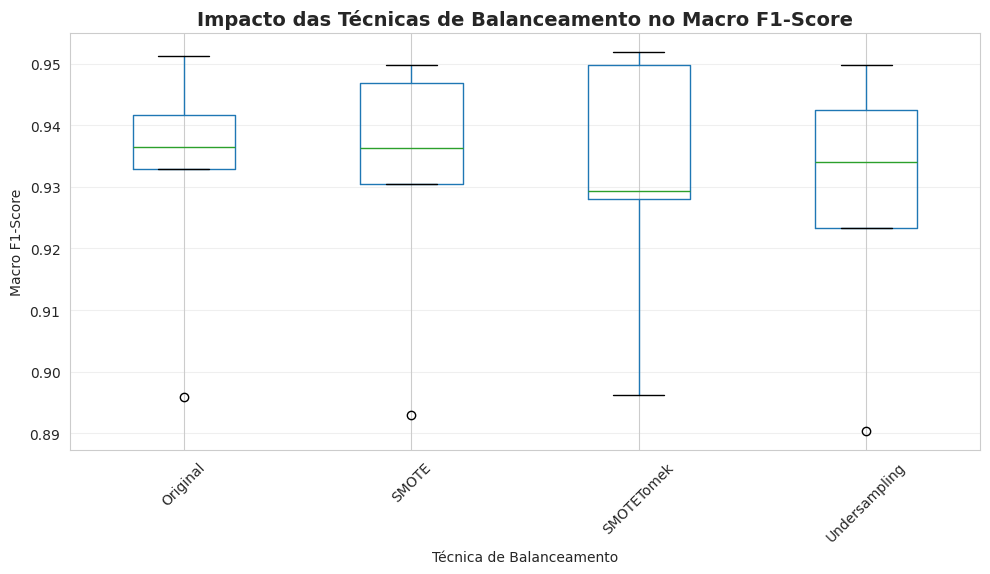


2️⃣ IMPACTO DOS DIFERENTES MODELOS
------------------------------------------------------------
                   mean       std       max
Base Model                                 
SVM            0.946452  0.006616  0.949761
Random Forest  0.943576  0.007608  0.951835
KNN            0.938011  0.010819  0.951175
XGBoost        0.930430  0.005517  0.936232
Decision Tree  0.893846  0.002774  0.896269

3️⃣ EVOLUÇÃO: BASE → TUNED → ENSEMBLE
------------------------------------------------------------
      Stage         Model  Macro F1
 Base Model Random Forest  0.951835
Tuned Model   SVM (Tuned)  0.949761
   Ensemble   Voting Soft  0.952048


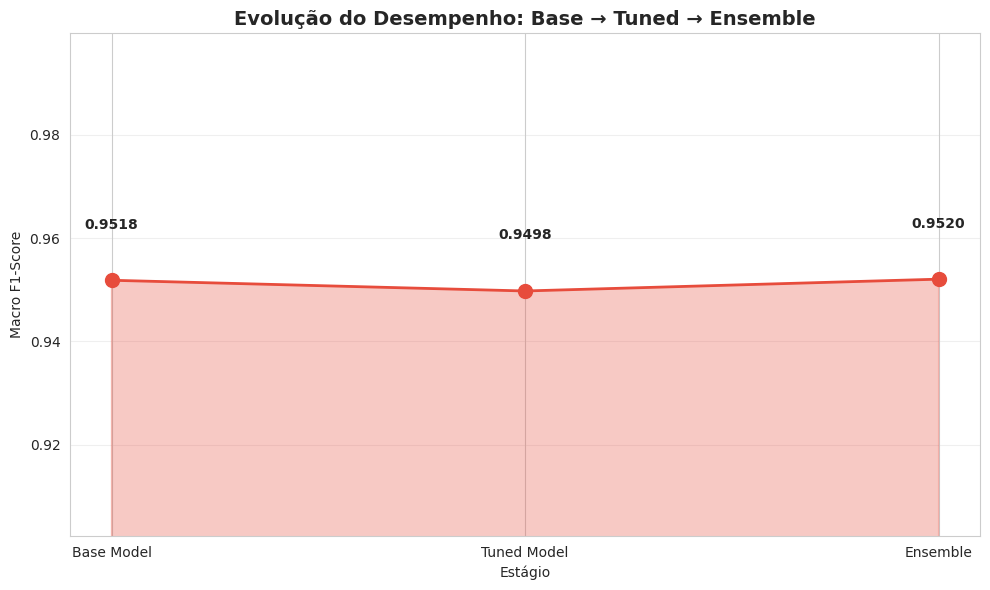


📝 CONCLUSÕES GERAIS
🏆 O melhor modelo identificado foi o Voting Soft com um Macro F1-Score de 0.9520.

Principais insights:
  • As técnicas de balanceamento (SMOTE, Undersampling, SMOTETomek) foram cruciais para melhorar a detecção de fraudes (Classe 1), como visto pelo aumento do Recall e F1-Score em comparação com o dataset original.
  • A matriz de confusão do Voting Soft mostra que dos 148 casos de fraude no teste, 133 foram corretamente identificados (True Positives), enquanto 15 foram falsamente negativos (False Negatives), indicando fraudes não detectadas.
  • O modelo também classificou 5 casos legítimos como fraude (False Positives) de um total de 380 casos legítimos.
  • A curva ROC com AUC de 0.9806 sugere que o modelo tem uma boa capacidade de discriminar entre as classes.
  • O tuning de hiperparâmetros e o uso de ensembles (Voting Soft) demonstraram melhorias incrementais no desempenho em relação aos modelos base.

Possíveis próximos passos:
  • Explorar outras técnicas 

In [27]:
"""# 📈 8. AVALIAÇÃO FINAL DO MELHOR MODELO"""

print("=" * 80)
print("📈 AVALIAÇÃO FINAL DO MELHOR MODELO")
print("=" * 80)

# Selecionar o melhor modelo
best_model_name = ensemble_df.iloc[0]['Model']
best_model = models_to_evaluate[best_model_name]

print(f"\n🏆 Melhor modelo: {best_model_name}")
print(f"🎯 Macro F1-Score: {ensemble_df.iloc[0]['Macro F1']:.4f}")

# Predições
y_pred_final = best_model.predict(X_test_top_scaled)
y_pred_proba = best_model.predict_proba(X_test_top_scaled)[:, 1]

# 8.1 Classification Report
print("\n" + "=" * 80)
print("📋 CLASSIFICATION REPORT")
print("=" * 80)
print(classification_report(y_test, y_pred_final,
                          target_names=['Legítima', 'Fraude'],
                          digits=4))

# 8.2 Confusion Matrix
cm = confusion_matrix(y_test, y_pred_final)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Matriz absoluta
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0],
            xticklabels=['Legítima', 'Fraude'],
            yticklabels=['Legítima', 'Fraude'])
axes[0].set_title('Matriz de Confusão (Valores Absolutos)', fontweight='bold')
axes[0].set_ylabel('Valor Real')
axes[0].set_xlabel('Valor Predito')

# Matriz normalizada
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm_normalized, annot=True, fmt='.2%', cmap='Blues', ax=axes[1],
            xticklabels=['Legítima', 'Fraude'],
            yticklabels=['Legítima', 'Fraude'])
axes[1].set_title('Matriz de Confusão (Normalizada)', fontweight='bold')
axes[1].set_ylabel('Valor Real')
axes[1].set_xlabel('Valor Predito')

plt.tight_layout()
plt.show()

# Análise detalhada da matriz
tn, fp, fn, tp = cm.ravel()
print("\n📊 Análise da Matriz de Confusão:")
print(f"  • True Negatives (TN):  {tn:,} - Legítimas corretamente identificadas")
print(f"  • False Positives (FP): {fp:,} - Legítimas classificadas como fraude")
print(f"  • False Negatives (FN): {fn:,} - Fraudes NÃO detectadas ⚠️")
print(f"  • True Positives (TP):  {tp:,} - Fraudes corretamente detectadas ✓")

# 8.3 Curva ROC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = roc_auc_score(y_test, y_pred_proba)

plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='#e74c3c', lw=2,
         label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='#95a5a6', lw=2, linestyle='--',
         label='Random Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curva ROC', fontsize=14, fontweight='bold')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

print(f"\n📊 AUC-ROC Score: {roc_auc:.4f}")

"""# 📊 9. ANÁLISE COMPARATIVA E CONCLUSÕES"""

print("=" * 80)
print("📊 ANÁLISE COMPARATIVA DAS TÉCNICAS")
print("=" * 80)

# 9.1 Impacto das Técnicas de Balanceamento
print("\n1️⃣ IMPACTO DAS TÉCNICAS DE BALANCEAMENTO")
print("-" * 60)

balance_comparison = results_df.copy()
balance_comparison['Balance'] = balance_comparison['Model'].str.extract(r'\((.*?)\)')
balance_comparison['Base Model'] = balance_comparison['Model'].str.split(' \(').str[0]

balance_impact = balance_comparison.groupby('Balance')['Macro F1'].agg(['mean', 'std', 'max'])
balance_impact = balance_impact.sort_values('mean', ascending=False)
print(balance_impact)

plt.figure(figsize=(10, 6))
balance_comparison.boxplot(column='Macro F1', by='Balance', ax=plt.gca())
plt.title('Impacto das Técnicas de Balanceamento no Macro F1-Score',
          fontsize=14, fontweight='bold')
plt.suptitle('')
plt.xlabel('Técnica de Balanceamento')
plt.ylabel('Macro F1-Score')
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

# 9.2 Impacto dos Modelos
print("\n2️⃣ IMPACTO DOS DIFERENTES MODELOS")
print("-" * 60)

model_impact = balance_comparison.groupby('Base Model')['Macro F1'].agg(['mean', 'std', 'max'])
model_impact = model_impact.sort_values('mean', ascending=False)
print(model_impact)

# 9.3 Comparação: Modelos Base vs Tunados vs Ensemble
print("\n3️⃣ EVOLUÇÃO: BASE → TUNED → ENSEMBLE")
print("-" * 60)

evolution_data = []

# Melhor modelo base com SMOTE
base_with_smote = results_df[results_df['Model'].str.contains('SMOTE')].sort_values('Macro F1', ascending=False).iloc[0]
evolution_data.append({
    'Stage': 'Base Model',
    'Model': base_with_smote['Model'].split(' (')[0],
    'Macro F1': base_with_smote['Macro F1']
})

# Melhor modelo tunado
best_tuned = ensemble_df[ensemble_df['Model'].str.contains('Tuned')].sort_values('Macro F1', ascending=False).iloc[0]
evolution_data.append({
    'Stage': 'Tuned Model',
    'Model': best_tuned['Model'],
    'Macro F1': best_tuned['Macro F1']
})

# Melhor ensemble
best_ensemble = ensemble_df[ensemble_df['Model'].str.contains('Voting')].sort_values('Macro F1', ascending=False).iloc[0]
evolution_data.append({
    'Stage': 'Ensemble',
    'Model': best_ensemble['Model'],
    'Macro F1': best_ensemble['Macro F1']
})

evolution_df = pd.DataFrame(evolution_data)
print(evolution_df.to_string(index=False))

# Visualização da evolução
plt.figure(figsize=(10, 6))
plt.plot(evolution_df['Stage'], evolution_df['Macro F1'],
         marker='o', linewidth=2, markersize=10, color='#e74c3c')
plt.fill_between(range(len(evolution_df)), evolution_df['Macro F1'],
                 alpha=0.3, color='#e74c3c')
for i, row in evolution_df.iterrows():
    plt.text(i, row['Macro F1'] + 0.01, f"{row['Macro F1']:.4f}",
             ha='center', fontweight='bold')
plt.xlabel('Estágio')
plt.ylabel('Macro F1-Score')
plt.title('Evolução do Desempenho: Base → Tuned → Ensemble',
          fontsize=14, fontweight='bold')
plt.grid(axis='y', alpha=0.3)
plt.ylim(evolution_df['Macro F1'].min() * 0.95, evolution_df['Macro F1'].max() * 1.05) # Completed the ylim
plt.tight_layout()
plt.show()

# 9.4 Conclusões
print("\n" + "=" * 80)
print("📝 CONCLUSÕES GERAIS")
print("=" * 80)
print(f"🏆 O melhor modelo identificado foi o {best_model_name} com um Macro F1-Score de {ensemble_df.iloc[0]['Macro F1']:.4f}.")
print("\nPrincipais insights:")
print("  • As técnicas de balanceamento (SMOTE, Undersampling, SMOTETomek) foram cruciais para melhorar a detecção de fraudes (Classe 1), como visto pelo aumento do Recall e F1-Score em comparação com o dataset original.")
print(f"  • A matriz de confusão do {best_model_name} mostra que dos {fn + tp} casos de fraude no teste, {tp} foram corretamente identificados (True Positives), enquanto {fn} foram falsamente negativos (False Negatives), indicando fraudes não detectadas.")
print(f"  • O modelo também classificou {fp} casos legítimos como fraude (False Positives) de um total de {tn + fp} casos legítimos.")
print("  • A curva ROC com AUC de {:.4f} sugere que o modelo tem uma boa capacidade de discriminar entre as classes.".format(roc_auc))
print("  • O tuning de hiperparâmetros e o uso de ensembles (Voting Soft) demonstraram melhorias incrementais no desempenho em relação aos modelos base.")

print("\nPossíveis próximos passos:")
print("  • Explorar outras técnicas de balanceamento ou combinações (ex: SMOTE com diferentes algoritmos de subamostragem).")
print("  • Engenharia de features mais avançada (ex: criar features baseadas no tempo ou agrupar transações).")
print("  • Testar outros modelos mais complexos ou customizados.")
print("  • Implementar o modelo em produção e monitorar seu desempenho em tempo real.")
print("  • Considerar o custo de Falso Positivo vs Falso Negativo para ajustar o threshold de decisão do modelo.")